In [1]:
#!pip install --user -U pip umap-learn seaborn biopython bioframe

In [44]:
from Bio import SeqIO
import bioframe as bf
from collections import Counter
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from umap import UMAP
from tqdm import tqdm
tqdm.pandas()

In [3]:
nucleotides = list("ACGT")
nucleotides

['A', 'C', 'G', 'T']

In [4]:
window_size = 1000000
center = 3566700

In [5]:
embedding_pos = np.load("example_embedding_1M_pos.1M.npy")
embedding_pos.shape

(1000000, 512)

In [6]:
embedding_neg = np.load("example_embedding_1M_neg.1M.npy")
embedding_neg.shape

(1000000, 512)

In [7]:
embedding = np.stack((embedding_pos, embedding_neg[::-1])).mean(axis=0)
embedding.shape

(1000000, 512)

## UMAP embedding of genomic windows

In [8]:
gtf = pd.read_csv(
    #"../../data/vep/tair10.gff",
    #"atRTD3_TS_21Feb22_transfix.gtf",
    "Arabidopsis_thaliana.TAIR10.54.chromosome.5.gff3.gz",
    sep='\t', header=None, comment="#",
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'],
)
gtf.chrom = gtf.chrom.astype(str)
gtf = gtf[gtf.chrom.isin(["Chr5", "chr5", "5"])]
gtf.shape

(180531, 9)

In [9]:
# To work with the already computed 1Mb embeddings
gtf = gtf[(gtf.start > center-window_size//2) & (gtf.end < center+window_size//2)]
gtf.start -= (center-window_size//2)
gtf.end -= (center-window_size//2)
gtf.shape

(8942, 9)

In [10]:
gtf_exon = gtf[gtf.feature=="exon"]

In [11]:
gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]
#gtf_exon["transcript_id"] = gtf_exon.attribute.str.split('"').str[3]

gtf_exon.transcript_id.value_counts()

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


AT5G12370.1    25
AT5G12370.3    25
AT5G12370.2    25
AT5G10470.2    23
AT5G10470.1    23
               ..
AT5G10040.1     1
AT5G11140.1     1
AT5G01675.2     1
AT5G01635.1     1
AT5G11230.1     1
Name: transcript_id, Length: 574, dtype: int64

In [12]:
import more_itertools

def get_transcript_introns(df_transcript):
    df_transcript = df_transcript.sort_values("start")
    exon_pairs = more_itertools.pairwise(df_transcript.loc[:, ["start", "end"]].values)
    introns = [[e1[1], e2[0]] for e1, e2 in exon_pairs]
    introns = pd.DataFrame(introns, columns=["start", "end"])
    introns["chrom"] = df_transcript.chrom.iloc[0]
    return introns

In [13]:
gtf_introns = gtf_exon.groupby("transcript_id").apply(get_transcript_introns).reset_index().drop_duplicates(subset=["chrom", "start", "end"])
gtf_introns["feature"] = "intron"
gtf_introns

,transcript_id,level_1,start,end,chrom,feature
0,AT5G01675.1,0,106810,107020,5,intron
1,AT5G01675.3,0,106810,112384,5,intron
2,AT5G01675.4,0,107142,112184,5,intron
3,AT5G01675.4,1,112196,112384,5,intron
4,AT5G01675.5,0,107076,112184,5,intron
...,...,...,...,...,...,...
3025,AT5G12850.1,0,989717,990339,5,intron
3026,AT5G12860.1,0,993589,993680,5,intron
3027,AT5G12860.1,1,993901,994131,5,intron
3028,AT5G12860.2,0,993150,993231,5,intron


In [14]:
gtf = pd.concat([gtf, gtf_introns], ignore_index=True)
gtf

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id,level_1
0,5,araport11,CDS,115,117,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
1,5,araport11,exon,217,300,.,+,.,Parent=transcript:AT5G09860.2;Name=AT5G09860.1...,NaN,NaN
2,5,araport11,CDS,217,300,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
3,5,araport11,exon,377,451,.,+,.,Parent=transcript:AT5G09860.2;Name=AT5G09860.1...,NaN,NaN
4,5,araport11,CDS,377,451,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10474,5,NaN,intron,989717,990339,NaN,NaN,NaN,NaN,AT5G12850.1,0.0
10475,5,NaN,intron,993589,993680,NaN,NaN,NaN,NaN,AT5G12860.1,0.0
10476,5,NaN,intron,993901,994131,NaN,NaN,NaN,NaN,AT5G12860.1,1.0
10477,5,NaN,intron,993150,993231,NaN,NaN,NaN,NaN,AT5G12860.2,0.0


In [15]:
gtf.feature.value_counts()

exon               3606
CDS                3242
intron             1537
five_prime_UTR      641
three_prime_UTR     560
mRNA                521
gene                280
ncRNA_gene           41
lnc_RNA              33
tRNA                  7
miRNA                 6
ncRNA                 2
snoRNA                2
snRNA                 1
Name: feature, dtype: int64

In [16]:
gtf.chrom = gtf.chrom.astype(str)
gtf.start = gtf.start.astype(int)
gtf.end = gtf.end.astype(int)

In [17]:
features_of_interest = ['CDS', 'five_prime_UTR', 'three_prime_UTR', 'intron']

In [66]:
W = 30
windows = pd.DataFrame(dict(start=np.arange(0+10000, window_size-W-10000, W)))
windows["end"] = windows.start + W
windows["chrom"] = gtf.chrom.iloc[0]

for f in features_of_interest:
    windows = bf.coverage(windows, gtf[gtf.feature==f])
    windows.rename(columns=dict(coverage=f), inplace=True)
windows

,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron
0,10000,10030,5,30,0,0,0
1,10030,10060,5,30,0,0,0
2,10060,10090,5,30,0,0,0
3,10090,10120,5,16,0,0,14
4,10120,10150,5,0,0,0,30
...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30
32662,989860,989890,5,0,0,0,30
32663,989890,989920,5,0,0,0,30
32664,989920,989950,5,0,0,0,30


In [67]:
windows["Region"]= np.nan
windows.loc[windows[features_of_interest].sum(axis=1)==0, "Region"] = "Intergenic"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==0)&(windows.intron==W), "Region"] = "Intron"
windows.loc[(windows.CDS==W)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==0)&(windows.intron==0), "Region"] = "CDS"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==W)&(windows.three_prime_UTR==0)&(windows.intron==0), "Region"] = "5' UTR"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==W)&(windows.intron==0), "Region"] = "3' UTR"
windows.Region.value_counts()

Intergenic    9056
CDS           8953
Intron        6052
3' UTR        2011
5' UTR        1418
Name: Region, dtype: int64

In [68]:
windows.dropna(inplace=True)
windows.shape

(27490, 8)

In [21]:
embedding_cols = np.arange(embedding.shape[1])
windows.loc[:, embedding_cols] = windows.apply(
    lambda row: embedding[row.start:row.end].sum(axis=0),
    axis=1,
    result_type="expand",
)
windows

,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,1,...,502,503,504,505,506,507,508,509,510,511
0,10000,10030,5,30,0,0,0,CDS,48.799446,-68.784454,...,-35.257946,-84.893097,49.379784,-23.641340,-13.350286,540.981079,-18.363571,-36.613136,-55.973656,-67.043724
1,10030,10060,5,30,0,0,0,CDS,-9.578766,-46.240112,...,2.795361,-87.377228,26.039774,-16.537128,-50.502407,529.303772,-25.243694,-61.782890,16.087982,-63.393799
2,10060,10090,5,30,0,0,0,CDS,11.515991,-47.186089,...,-46.783924,-95.630768,8.079172,2.105617,-34.774277,303.950470,35.382092,-14.690739,34.036526,-86.721260
4,10120,10150,5,0,0,0,30,Intron,27.783051,-67.995430,...,24.847254,-79.094887,25.930182,-2.702695,-52.538502,165.135620,31.343834,-88.506706,-60.262772,-87.588318
5,10150,10180,5,0,0,0,30,Intron,58.458065,-55.869610,...,19.588535,-76.574455,3.586490,-9.041407,-46.245106,185.314087,57.126122,-62.416996,-31.942648,-78.448425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30,Intron,-11.199146,-58.020889,...,-52.409630,-51.705643,-38.588120,-35.857777,-46.723499,294.459076,22.908836,-55.281403,-75.594978,-72.691528
32662,989860,989890,5,0,0,0,30,Intron,-37.481674,-65.580193,...,-30.310419,-47.097710,-23.463713,-47.544815,-60.446907,62.635651,45.465424,-95.398628,-74.522339,-74.551521
32663,989890,989920,5,0,0,0,30,Intron,-40.747505,-77.442459,...,-34.765785,-19.605587,-33.934292,-47.390900,-65.486771,135.816315,32.683609,-91.112617,-90.078682,-84.829521
32664,989920,989950,5,0,0,0,30,Intron,-44.835197,-59.714256,...,-35.644855,-59.249161,-34.749947,-26.800097,-55.402817,219.979309,27.398153,-72.843903,-86.265526,-78.237488


In [69]:
projector = Pipeline([
    ("scaler", StandardScaler()),
    #("pca", PCA(n_components=10)),
    ("umap", UMAP(n_components=2, n_neighbors=15, random_state=42, min_dist=0.1)),
])

In [22]:
windows[["UMAP1", "UMAP2"]] = projector.fit_transform(windows[embedding_cols])

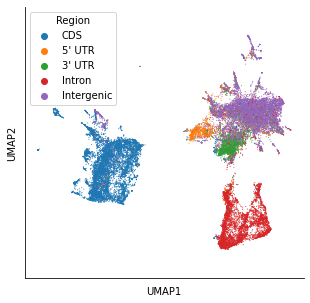

In [23]:
region_order = ["CDS", "5' UTR", "3' UTR", "Intron", "Intergenic"]


plt.figure(figsize=(5, 5))
g = sns.scatterplot(
    data=windows,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=1,
    linewidth=0,
    palette="tab10",
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');
#plt.savefig("umap_embedding.svg", bbox_inches="tight");

## Alternative: k-mer features

In [74]:
# source: https://github.com/MindAI/kmer

class kmer_featurization:

  def __init__(self, k):
    """
    seqs: a list of DNA sequences
    k: the "k" in k-mer
    """
    self.k = k
    self.letters = ['A', 'T', 'C', 'G']
    self.multiplyBy = 4 ** np.arange(k-1, -1, -1) # the multiplying number for each digit position in the k-number system
    self.n = 4**k # number of possible k-mers

  def obtain_kmer_feature_for_a_list_of_sequences(self, seqs, write_number_of_occurrences=False):
    """
    Given a list of m DNA sequences, return a 2-d array with shape (m, 4**k) for the 1-hot representation of the kmer features.
    Args:
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.    
    """
    kmer_features = []
    for seq in seqs:
      this_kmer_feature = self.obtain_kmer_feature_for_one_sequence(seq.upper(), write_number_of_occurrences=write_number_of_occurrences)
      kmer_features.append(this_kmer_feature)

    kmer_features = np.array(kmer_features)

    return kmer_features

  def obtain_kmer_feature_for_one_sequence(self, seq, write_number_of_occurrences=False):
    """
    Given a DNA sequence, return the 1-hot representation of its kmer feature.
    Args:
      seq: 
        a string, a DNA sequence
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.
    """
    number_of_kmers = len(seq) - self.k + 1

    kmer_feature = np.zeros(self.n)

    for i in range(number_of_kmers):
      this_kmer = seq[i:(i+self.k)]
      this_numbering = self.kmer_numbering_for_one_kmer(this_kmer)
      kmer_feature[this_numbering] += 1

    if not write_number_of_occurrences:
      kmer_feature = kmer_feature / number_of_kmers

    return kmer_feature

  def kmer_numbering_for_one_kmer(self, kmer):
    """
    Given a k-mer, return its numbering (the 0-based position in 1-hot representation)
    """
    digits = []
    for letter in kmer:
      digits.append(self.letters.index(letter))

    digits = np.array(digits)

    numbering = (digits * self.multiplyBy).sum()

    return numbering

In [75]:
import gzip
from Bio import SeqIO
import pandas as pd


def load_fasta(path):
    with gzip.open(path, "rt") if path.endswith(".gz") else open(path) as handle:
        return SeqIO.to_dict(SeqIO.parse(handle, "fasta"))


class Genome:
    def __init__(self, path):
        self.genome = load_fasta(path)

    def get_window_seq(self, window):
        seq = self.genome[window.chrom][window.start:window.end].seq
        if window.strand == "-":
            seq = seq.reverse_complement()
        return str(seq)

In [76]:
genome = Genome("../../data/mlm/genome/Arabidopsis_thaliana.fa.gz")

In [77]:
# Think about whether to have kmers over 30-bp or 512-bp windows

In [78]:
windowsk = windows.copy()
windowsk["strand"] = "+"
windowsk["seq"] = windowsk.progress_apply(lambda w: genome.get_window_seq(w).upper(), axis=1)
windowsk

100%|██████████| 27490/27490 [00:01<00:00, 22673.62it/s]


,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,strand,seq
0,10000,10030,5,30,0,0,0,CDS,+,TTCCGTGGTTGTGTTTTTCGATTTTGCTTC
1,10030,10060,5,30,0,0,0,CDS,+,TACTCCACGTTCTTGTTGTTGTTCCCTTTT
2,10060,10090,5,30,0,0,0,CDS,+,AGCTCCAGATTATGCTTTTCTTTTTGTTTT
4,10120,10150,5,0,0,0,30,Intron,+,GAGTCTCAGTTTAATGAAATGTTTGTGGAT
5,10150,10180,5,0,0,0,30,Intron,+,TTTTGGTAAATAGTACTAATGGGTATGTTT
...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30,Intron,+,TTGATTGGTTCATATTTGAAACGTTTATCT
32662,989860,989890,5,0,0,0,30,Intron,+,GGTTTTCGACCAAACAGCTTCACAAGAGAG
32663,989890,989920,5,0,0,0,30,Intron,+,ATAACAATTCCCATGTAAACCCTTTCAACA
32664,989920,989950,5,0,0,0,30,Intron,+,AAGAGCATCACCGACATTGTCAAACAGATG


1


100%|██████████| 27490/27490 [00:03<00:00, 7572.85it/s]


2


100%|██████████| 27490/27490 [00:03<00:00, 7550.51it/s]


3


100%|██████████| 27490/27490 [00:03<00:00, 7493.14it/s]


4


100%|██████████| 27490/27490 [00:05<00:00, 5216.68it/s]


5


100%|██████████| 27490/27490 [00:04<00:00, 6775.30it/s]


6


100%|██████████| 27490/27490 [00:04<00:00, 6476.70it/s]


7


100%|██████████| 27490/27490 [00:05<00:00, 4794.76it/s]


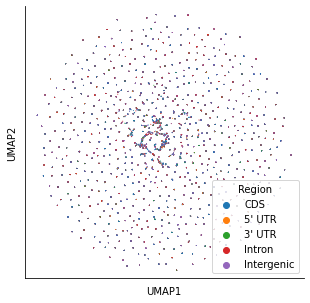

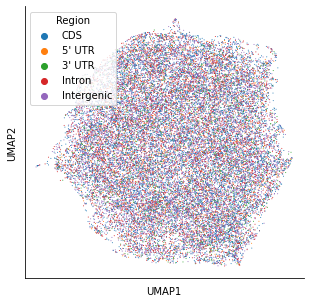

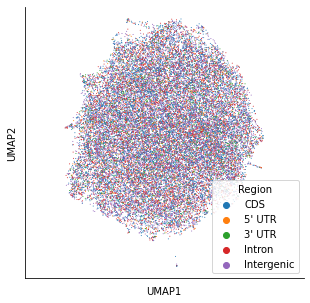

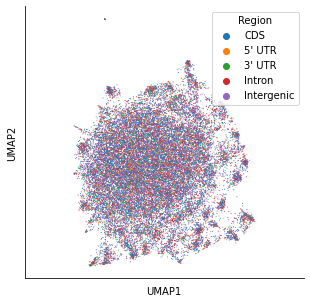

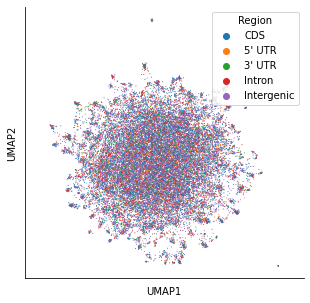

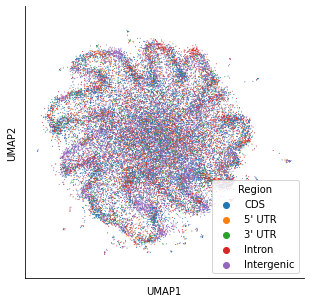

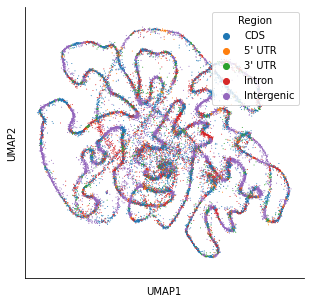

In [79]:
for K in range(1, 8):
    print(K)
    kmer_counter = kmer_featurization(K)
    windowsk["kmer_features"] = windowsk.seq.progress_apply(lambda seq: kmer_counter.obtain_kmer_feature_for_one_sequence(seq))
    windowsk[["UMAP1", "UMAP2"]] = projector.fit_transform(np.stack(windowsk["kmer_features"].values))
    plt.figure(figsize=(5, 5))
    g = sns.scatterplot(
        data=windowsk,
        x="UMAP1",
        y="UMAP2",
        hue="Region",
        hue_order=region_order,
        s=1,
        linewidth=0,
        palette="tab10",
    )
    sns.despine()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('equal');
    plt.savefig(f"umap_{K}mer.pdf", bbox_inches="tight");

## Interpretation of clusters

In [69]:
import scanpy as sc
import anndata

adata = anndata.AnnData(StandardScaler().fit_transform(windows[embedding_cols]))
adata

AnnData object with n_obs × n_vars = 27490 × 512

In [70]:
sc.tl.pca(adata, n_comps=100)
adata

AnnData object with n_obs × n_vars = 27490 × 512
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [71]:
sc.pp.neighbors(
    adata,
    n_neighbors=30,
    n_pcs=100,
    #use_rep="X"
)

In [72]:
sc.tl.leiden(
    adata, 
    resolution=0.28,
    random_state=0,
)
windows["cluster"] = adata.obs.leiden.values.astype(str)

In [73]:
windows.cluster.value_counts()

0    8381
1    8104
2    5172
3    2403
4    1172
5    1142
6     560
7     556
Name: cluster, dtype: int64

In [2]:
#windows.to_csv("windows.tsv.gz", sep="\t")  # unfortunately scanpy is not fully deterministic
#windows = pd.read_csv("windows.tsv.gz", sep="\t")
#windows

,Unnamed: 0,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,...,510,511,UMAP1,UMAP2,cluster,transcript_id_closest_tss,distance_closest_tss,transcript_id_closest_tes,distance_closest_tes,repeat
0,0,10000,10030,5,30,0,0,0,CDS,48.799446,...,-55.973656,-67.043724,-0.668655,3.959783,1,AT5G09876.1,3157,AT5G09870.1,1686,0
1,1,10030,10060,5,30,0,0,0,CDS,-9.578766,...,16.087982,-63.393800,-0.656283,4.300891,1,AT5G09876.1,3127,AT5G09870.1,1656,0
2,2,10060,10090,5,30,0,0,0,CDS,11.515991,...,34.036526,-86.721260,-1.386047,3.996775,1,AT5G09876.1,3097,AT5G09870.1,1626,0
3,4,10120,10150,5,0,0,0,30,Intron,27.783050,...,-60.262770,-87.588320,10.864657,0.181586,2,AT5G09876.1,3037,AT5G09870.1,1566,0
4,5,10150,10180,5,0,0,0,30,Intron,58.458065,...,-31.942648,-78.448425,11.685802,0.125930,2,AT5G09876.1,3007,AT5G09870.1,1536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27485,32661,989830,989860,5,0,0,0,30,Intron,-11.199146,...,-75.594980,-72.691530,9.286081,2.048479,2,AT5G12850.1,443,AT5G12860.1,3019,0
27486,32662,989860,989890,5,0,0,0,30,Intron,-37.481674,...,-74.522340,-74.551520,9.422347,2.216570,2,AT5G12850.1,473,AT5G12860.1,2989,0
27487,32663,989890,989920,5,0,0,0,30,Intron,-40.747505,...,-90.078680,-84.829520,9.475478,2.239206,2,AT5G12850.1,503,AT5G12860.1,2959,0
27488,32664,989920,989950,5,0,0,0,30,Intron,-44.835197,...,-86.265526,-78.237490,9.443623,2.197510,2,AT5G12850.1,533,AT5G12860.1,2929,0


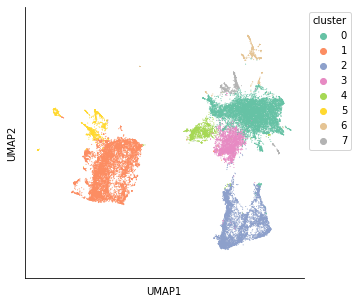

In [81]:
plt.figure(figsize=(5, 5))
g = sns.scatterplot(
    data=windows,#windows.query('cluster != "8"'),
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    hue_order=np.unique(windows.cluster.values),
    s=1,
    linewidth=0,
    palette="Set2",
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("umap_embedding_clustering.svg", bbox_inches="tight");

In [3]:
counts = windows.groupby(['cluster','Region']).Region.count().unstack().fillna(0)
counts = counts.loc[np.arange(len(windows.cluster.unique())).astype(str), region_order]
counts

NameError: name 'region_order' is not defined

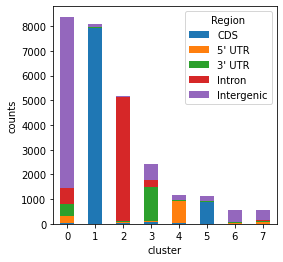

In [113]:
counts.plot(
    kind='bar',
    stacked=True,
    figsize=(4,4),
    rot=0,
)
plt.ylabel("counts")
plt.savefig("results/plots/cluster_composition.svg", bbox_inches="tight");

<AxesSubplot:xlabel='cluster'>

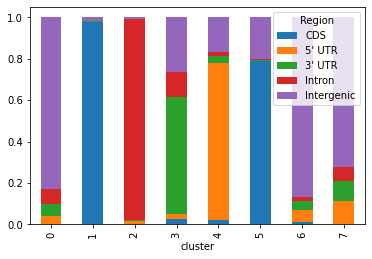

In [114]:
counts.div(counts.sum(axis=1), axis=0).plot(kind='bar', stacked=True)

In [85]:
(windows.query("cluster=='5'").sample(n=10).start + center-window_size//2).values

array([3113570, 3220010, 3638690, 3815300, 3113840, 3913190, 3913700,
       3637520, 3472670, 3133640])

In [86]:
(windows.query("cluster=='5' and Region=='Intergenic'").sample(n=10).start + center-window_size//2).values

array([3908600, 3786170, 3786710, 3906500, 3815270, 3786230, 3786530,
       3908120, 3908900, 3907190])

In [87]:
cluster_5_intervals = bf.merge(windows.query('cluster=="5" and Region=="Intergenic"'))
cluster_5_intervals.loc[:, ["start", "end"]] += center - window_size // 2
cluster_5_intervals

,chrom,start,end,n_intervals
0,5,3095630,3095660,1
1,5,3372350,3372740,13
2,5,3627740,3627830,3
3,5,3688520,3688760,8
4,5,3714350,3714650,10
5,5,3714920,3715040,4
6,5,3786170,3786740,19
7,5,3815150,3815510,12
8,5,3904940,3909320,146
9,5,3936020,3936410,13


In [88]:
10210 + center-window_size//2

3076910

In [89]:
gtf.query('start > 9900 and end < 10500')

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id,level_1
103,5,araport11,exon,9907,10106,.,+,.,Parent=transcript:AT5G09870.1;Name=AT5G09870.1...,NaN,NaN
104,5,araport11,CDS,9907,10106,.,+,2,ID=CDS:AT5G09870.1;Parent=transcript:AT5G09870...,NaN,NaN
8984,5,NaN,intron,10106,10205,NaN,NaN,NaN,NaN,AT5G09870.1,10.0


In [90]:
target_genes = bf.coverage(gtf.query('feature=="gene"'), windows.query('cluster=="5"')).query('coverage > 0').attribute.str.split(";").str[0].str.split(":").str[-1].unique()
target_genes

array(['AT5G09870', 'AT5G09890', 'AT5G09930', 'AT5G09950', 'AT5G09970',
       'AT5G10020', 'AT5G10100', 'AT5G10140', 'AT5G10260', 'AT5G10270',
       'AT5G10280', 'AT5G10290', 'AT5G10340', 'AT5G10370', 'AT5G10380',
       'AT5G10390', 'AT5G10400', 'AT5G10420', 'AT5G10470', 'AT5G10500',
       'AT5G10510', 'AT5G10520', 'AT5G10540', 'AT5G10530', 'AT5G10570',
       'AT5G10610', 'AT5G10690', 'AT5G10930', 'AT5G10970', 'AT5G10980',
       'AT5G10990', 'AT5G11010', 'AT5G11020', 'AT5G11050', 'AT5G11190',
       'AT5G11200', 'AT5G11250', 'AT5G11310', 'AT5G11320', 'AT5G11360',
       'AT5G11370', 'AT5G11400', 'AT5G11410', 'AT5G11412', 'AT5G11480',
       'AT5G11565', 'AT5G11590', 'AT5G11850', 'AT5G11940', 'AT5G12000',
       'AT5G12090', 'AT5G12100', 'AT5G12180', 'AT5G12250', 'AT5G12270',
       'AT5G12440', 'AT5G12480'], dtype=object)

In [91]:
background_genes = gtf.query('feature=="gene"').attribute.str.extract(r'gene:([^;]*);')
background_genes

,0
80,AT5G09870
110,AT5G09876
118,AT5G09880
148,AT5G09890
203,AT5G09900
...,...
8776,AT5G12480
8821,AT5G12840
8905,AT5G12850
8913,AT5G12860


In [92]:
background_genes.to_csv("background_genes.csv", header=False, index=False)

In [93]:
len(target_genes), len(background_genes)

(57, 280)

In [94]:
for gene in target_genes: print(gene)

AT5G09870
AT5G09890
AT5G09930
AT5G09950
AT5G09970
AT5G10020
AT5G10100
AT5G10140
AT5G10260
AT5G10270
AT5G10280
AT5G10290
AT5G10340
AT5G10370
AT5G10380
AT5G10390
AT5G10400
AT5G10420
AT5G10470
AT5G10500
AT5G10510
AT5G10520
AT5G10540
AT5G10530
AT5G10570
AT5G10610
AT5G10690
AT5G10930
AT5G10970
AT5G10980
AT5G10990
AT5G11010
AT5G11020
AT5G11050
AT5G11190
AT5G11200
AT5G11250
AT5G11310
AT5G11320
AT5G11360
AT5G11370
AT5G11400
AT5G11410
AT5G11412
AT5G11480
AT5G11565
AT5G11590
AT5G11850
AT5G11940
AT5G12000
AT5G12090
AT5G12100
AT5G12180
AT5G12250
AT5G12270
AT5G12440
AT5G12480


In [95]:
(windows.query('cluster=="6"').start + center-window_size//2).head(20)

86      3079280
87      3079310
88      3079340
89      3079370
90      3079400
91      3079430
92      3079460
634     3095720
977     3106010
1246    3114080
1253    3114290
1254    3114320
1255    3114350
1256    3114380
1257    3114410
1258    3114440
1259    3114470
1260    3114500
1261    3114530
1262    3114560
Name: start, dtype: int64

In [21]:
gtf_mRNA = gtf[gtf.feature=="mRNA"].copy()
gtf_mRNA["transcript_id"] = gtf_mRNA.attribute.str.extract(r'transcript:([^;]*);')
mRNA_boundaries = gtf_mRNA.groupby("transcript_id").agg({"chrom": "first", "start": "min", "end": "max", "strand": "first"}).reset_index()

tss = mRNA_boundaries.copy()
tss.start = tss.apply(lambda row: row.start if row.strand=="+" else row.end, axis=1)
tss.end = tss.start + 1

tes = mRNA_boundaries.copy()
tes.start = tes.apply(lambda row: row.start if row.strand=="-" else row.end, axis=1)
tes.end = tes.start + 1

tss

,transcript_id,chrom,start,end,strand
0,AT5G09870.1,5,6170,6171,+
1,AT5G09876.1,5,13187,13188,+
2,AT5G09880.1,5,18591,18592,-
3,AT5G09890.1,5,22419,22420,-
4,AT5G09890.2,5,22310,22311,-
...,...,...,...,...,...
516,AT5G12840.5,5,986834,986835,-
517,AT5G12850.1,5,989386,989387,+
518,AT5G12860.1,5,995589,995590,-
519,AT5G12860.2,5,995250,995251,-


In [25]:
windows.chrom = windows.chrom.astype(str)
windows.loc[:, ["transcript_id_closest_tss", "distance_closest_tss"]] = bf.closest(windows[["chrom", "start", "end"]], tss, suffixes=('','_closest_tss'))[["transcript_id_closest_tss", "distance"]].values
windows.loc[:, ["transcript_id_closest_tes", "distance_closest_tes"]] = bf.closest(windows[["chrom", "start", "end"]], tes, suffixes=('','_closest_tes'))[["transcript_id_closest_tes", "distance"]].values
windows

,Unnamed: 0,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,...,510,511,UMAP1,UMAP2,cluster,transcript_id_closest_tss,distance_closest_tss,transcript_id_closest_tes,distance_closest_tes,repeat
0,0,10000,10030,5,30,0,0,0,CDS,48.799446,...,-55.973656,-67.043724,-0.668655,3.959783,1,AT5G09876.1,3157,AT5G09870.1,1686,0
1,1,10030,10060,5,30,0,0,0,CDS,-9.578766,...,16.087982,-63.393800,-0.656283,4.300891,1,AT5G09876.1,3127,AT5G09870.1,1656,0
2,2,10060,10090,5,30,0,0,0,CDS,11.515991,...,34.036526,-86.721260,-1.386047,3.996775,1,AT5G09876.1,3097,AT5G09870.1,1626,0
3,4,10120,10150,5,0,0,0,30,Intron,27.783050,...,-60.262770,-87.588320,10.864657,0.181586,2,AT5G09876.1,3037,AT5G09870.1,1566,0
4,5,10150,10180,5,0,0,0,30,Intron,58.458065,...,-31.942648,-78.448425,11.685802,0.125930,2,AT5G09876.1,3007,AT5G09870.1,1536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27485,32661,989830,989860,5,0,0,0,30,Intron,-11.199146,...,-75.594980,-72.691530,9.286081,2.048479,2,AT5G12850.1,443,AT5G12860.1,3019,0
27486,32662,989860,989890,5,0,0,0,30,Intron,-37.481674,...,-74.522340,-74.551520,9.422347,2.216570,2,AT5G12850.1,473,AT5G12860.1,2989,0
27487,32663,989890,989920,5,0,0,0,30,Intron,-40.747505,...,-90.078680,-84.829520,9.475478,2.239206,2,AT5G12850.1,503,AT5G12860.1,2959,0
27488,32664,989920,989950,5,0,0,0,30,Intron,-44.835197,...,-86.265526,-78.237490,9.443623,2.197510,2,AT5G12850.1,533,AT5G12860.1,2929,0


In [26]:
intergenic_clusters = ["0", "6", "7"]
palette = {"0": "#66c2a5", "6": "#e5c494", "7": "#b3b3b3"}  # https://loading.io/color/feature/Set2-8/

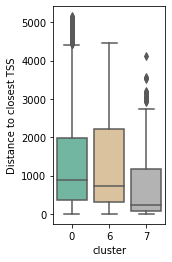

In [31]:
windows.cluster = windows.cluster.astype(str)
plt.figure(figsize=(2, 4))
g = sns.boxplot(
    data=windows[windows.cluster.isin(intergenic_clusters)].query('Region=="Intergenic"'),
    y="distance_closest_tss",
    x="cluster",
    order=intergenic_clusters,
    palette=palette,#"Set2",
)
plt.ylabel("Distance to closest TSS")
plt.savefig("results/plots/cluster_dist_tss.svg", bbox_inches="tight");

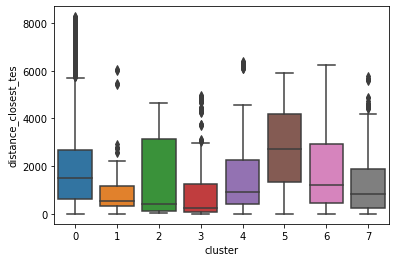

In [102]:
g = sns.boxplot(
    data=windows.query('Region=="Intergenic"'),
    y="distance_closest_tes",
    x="cluster",
    order=np.unique(windows.cluster.values),
)

In [103]:
windows.query('cluster=="7"')

,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,1,...,510,511,UMAP1,UMAP2,cluster,transcript_id_closest_tss,distance_closest_tss,transcript_id_closest_tes,distance_closest_tes,repeat
100,13000,13030,5,0,0,0,0,Intergenic,-15.179518,-71.377007,...,-27.336302,-1.421216,13.074135,5.862715,7,AT5G09876.1,157,AT5G09876.1,705,0
101,13030,13060,5,0,0,0,0,Intergenic,-58.513607,-55.638275,...,-1.213171,-16.063423,13.404788,5.396633,7,AT5G09876.1,127,AT5G09876.1,675,0
102,13060,13090,5,0,0,0,0,Intergenic,-24.585991,-33.019440,...,-69.862885,-77.133339,13.383141,5.412035,7,AT5G09876.1,97,AT5G09876.1,645,0
287,18610,18640,5,0,0,0,0,Intergenic,-15.922668,-87.707367,...,-20.618025,-48.697289,13.475411,5.216140,7,AT5G09880.1,18,AT5G09890.1,204,0
288,18640,18670,5,0,0,0,0,Intergenic,13.695176,-47.833805,...,-20.657629,-39.078648,9.984356,10.832220,7,AT5G09880.1,48,AT5G09890.1,174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32184,975520,975550,5,0,30,0,0,5' UTR,54.301170,-89.595337,...,-6.101176,-47.602715,8.844705,10.558543,7,AT5G12440.8,4,AT5G12450.1,1043,0
32186,975580,975610,5,0,0,0,0,Intergenic,56.620377,-86.795197,...,12.825058,-73.001747,9.943767,11.334733,7,AT5G12440.4,25,AT5G12450.1,1103,0
32187,975610,975640,5,0,0,0,0,Intergenic,38.913166,-26.108908,...,23.767885,-66.699768,10.022860,11.001791,7,AT5G12440.4,55,AT5G12450.1,1133,0
32188,975640,975670,5,0,0,0,0,Intergenic,106.977547,-63.862389,...,-32.356533,-52.124493,9.839690,11.611753,7,AT5G12440.4,85,AT5G12450.1,1163,0


In [104]:
cluster_6_target_genes = windows.query('cluster=="6" and distance_closest_tss < 500').transcript_id_closest_tss.str.split('.').str[0].drop_duplicates()
cluster_6_target_genes.to_csv('target_genes_cluster_6.csv', index=False, header=False)

In [105]:
cluster_7_intervals = bf.merge(windows.query('cluster=="7"'))
cluster_7_intervals.loc[:, ["start", "end"]] += center - window_size // 2
cluster_7_intervals

,chrom,start,end,n_intervals
0,5,3079700,3079790,3
1,5,3085310,3085430,4
2,5,3092600,3092750,5
3,5,3106040,3106160,4
4,5,3106190,3106220,1
...,...,...,...,...
211,5,4019660,4019720,2
212,5,4019930,4019960,1
213,5,4024010,4024100,3
214,5,4042160,4042250,3


In [106]:
repeats = pd.read_csv("../../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats = repeats.query('chrom == "Chr5"')
repeats.chrom = "5"
repeats.start -= center - window_size//2
repeats.end -= center - window_size//2

repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
54049,10,5820,34,4,1,5,9516162,9516848,-14391954,+,ATCopia28_I-int,LTR,Copia,4019,4706,0,5
54050,10,636,309,61,82,5,11612992,11613905,-12294897,-,ATMU1,DNA,MULE-MuDR,-2610,2319,902,5
54051,77,16502,18,0,1,5,2044667,2046550,-21862252,+,ATMU12,DNA,MULE-MuDR,1,1882,-2465,5
54052,78,16,132,0,0,5,3093675,3093700,-20815102,+,(T)n,Simple_repeat,Simple_repeat,1,25,0,5
54053,81,19,219,24,74,5,5977241,5977326,-17931476,+,GA-rich,Low_complexity,Low_complexity,1,81,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69150,790,18,171,42,20,5,23899227,23899275,-9527,+,GA-rich,Low_complexity,Low_complexity,1,49,0,6
69151,790,22,0,0,0,5,23899663,23899687,-9115,+,(T)n,Simple_repeat,Simple_repeat,1,24,0,6
69152,790,15,55,0,0,5,23903897,23903916,-4886,+,(T)n,Simple_repeat,Simple_repeat,1,19,0,6
69153,790,12,218,27,0,5,23904335,23904372,-4430,+,A-rich,Low_complexity,Low_complexity,1,38,0,6


In [107]:
windows["repeat"] = (bf.coverage(windows[["chrom", "start", "end"]], repeats).coverage > 0).values.astype(int)

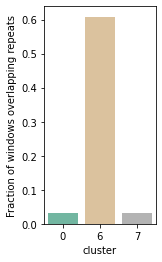

In [108]:
plt.figure(figsize=(2, 4))
g = sns.barplot(
    data=windows[windows.cluster.isin(intergenic_clusters)].query('Region=="Intergenic"'),
    y="repeat",
    x="cluster",
    order=intergenic_clusters,
    palette=palette,
    ci=None,
)
plt.ylabel("Fraction of windows overlapping repeats")
plt.savefig("results/plots/cluster_repeats.svg", bbox_inches="tight");

In [109]:
windows.query('Region=="Intergenic"').groupby("cluster").repeat.mean()

cluster
0    0.031389
1    0.196850
2    0.000000
3    0.023734
4    0.138462
5    0.716157
6    0.608247
7    0.032338
Name: repeat, dtype: float64

In [110]:
from sklearn.metrics import adjusted_rand_score

In [111]:
adjusted_rand_score(windows.Region, windows.cluster)

0.668236018261217